# Running Performance Boundary

Running is a hobby of mine that I try to keep up with, so naturally I was curious if there was any data about
it that I could find and analyze. This notebook is the result of that curiosity&mdash;specifically, I was curious
if there were any insights that I might be able to glean from official performance data.

The data sets used in this notebook are a conglomerate of olympic performances and marathons (half, regular, and
ultra). First, we need to parse these datasets and combine them into a single dataframe.

In [1]:
import numpy as np
import pandas as pd
from glob import glob

dfs = []
def parse_time(s):
    sp = s.split(':')
    try:
        return np.array(['0']*(3-len(sp)) + sp).astype(float)@[3600,60,1]
    except ValueError as e:
        return None

In [2]:
def parse_olympic(fname):
    df = pd.read_csv(fname, names = 
        ['Gender',
         'Event',
         'Location',
         'Year',
         'Medal',
         'Name',
         'Nationality',
         'Result',
         'Wind'], skiprows=1)
    df['distance'] = df.Event.str.extract('^([0-9]+)M (Men|Women)$')[0].astype(float)/1e3
    df['time'] = df.Result.apply(parse_time)/60
    df['pace'] = df.time/df.distance
    df['source'] = 'olympics'
    return df[['source','distance','time','pace']].dropna()

dfs += [parse_olympic('../input/olympic-track-field-results/results.csv')]

In [3]:
def parse_utmb(fname_pat):
    files = pd.DataFrame(glob(fname_pat), columns=['fname'])
    files['csvs'] = files.fname.apply(pd.read_csv)
    files['year'] = files.fname.str.extract('.*utmb_([0-9]*)\.csv').astype(int)
    bad_years = [2010, 2012, 2017]
    files = files[~files.year.isin(bad_years)]
    df = pd.concat(files.csvs.values, keys=files.year, join='inner')
    df['source'] = ('utmb_' + df.index.get_level_values('year').to_series().astype(str)).values
    df['time'] = df.time.astype(str).apply(parse_time)/60
    df['distance'] = 171
    df['pace'] = df.time/df.distance
    return df[['source', 'distance', 'time', 'pace']].dropna()

dfs += [parse_utmb('../input/ultratrail-du-montblanc-20032017/utmb_*.csv')]

In [4]:
def parse_boston(fname_pat):
    files = pd.DataFrame(glob(fname_pat), columns=['fname'])
    files['csvs'] = files.fname.apply(pd.read_csv)
    files['year'] = files.fname.str.extract('.*marathon_results_([0-9]*)\.csv').astype(int)
    df = pd.concat(files.csvs.values, keys=files.year, join='inner')
    df['time'] = df['Official Time'].apply(parse_time)/60
    df['distance'] = 42.195
    df['pace'] = df.time/df.distance
    df['source'] = ('boston_' + df.index.get_level_values('year').to_series().astype(str)).values
    return df[['source', 'distance', 'time', 'pace']].dropna()
dfs += [parse_boston('../input/boston-results/marathon_results_*.csv')]

In [5]:
def parse_hong_kong(fname_pat):
    files = pd.DataFrame(glob(fname_pat), columns=['fname'])
    files['csvs'] = files.fname.apply(pd.read_csv)
    files['type'] = files.fname.str.extract('.*/(.*)\.csv')
    df = pd.concat(files.csvs.values, keys=files.type, join='inner')
    df['time'] = df['Official Time'].apply(parse_time)/60
    df['distance'] = 42.195
    df['pace'] = df.time/df.distance
    df['source'] = ('hong_kong_2016_' + df.index.get_level_values('type').to_series()).values
    return df[['source', 'distance', 'time', 'pace']].dropna()
dfs += [parse_hong_kong('../input/hong-kong-marathon-2016/*.csv')]

In [6]:
distance_mapping = {
    '3000Metres': 3.0,
    '5000Metres': 5.0,
    '10,000Metres': 10.0,
    '10Kilometres': 10.0,
    'HalfMarathon': 21.0975,
    '1500Metres': 1.5,
    'Marathon': 42.195,
    '5Kilometres': 5.0,
    '12Kilometres': 12.0,
    '15Kilometres': 15.0,
    '800Metres': 0.8,
    '1000Metres': 1.0,
    '500Metres': 0.5,
    'OneMile': 1.60934,
    '2000Metres': 2.0,
    'TwoMiles': 3.21869,
    '20Kilometres': 20.0,
    '25Kilometres': 25.0,
    '30Kilometres': 30.0,
    '8Kilometres': 8.0,
    '200Metres': 0.2,
    '400Metres': 0.4,
    '20,000Metres': 20.0,
    '100Kilometres': 100.0,
    '5MilesRoad': 8.04672,
    '100Metres': 0.1,
    '55Metres': 0.055,
    '600Metres': 0.6,
    '300Metres': 0.3,
    '60Metres': 0.06,
    '30,000Metres': 30.0,
}

def parse_half_marathon(fname_pat):
    files = pd.DataFrame(glob(fname_pat), columns=['fname'])
    files['csvs'] = files.fname.apply(pd.read_csv)
    files['type'] = files.fname.str.extract('.*/(.*)\.csv')
    df = pd.concat(files.csvs.values, keys=files.type, join='inner')
    df['distance'] = df.Discipline.apply(lambda x: distance_mapping[x] if x in distance_mapping else np.nan)
    df['time'] = df.Performance.apply(parse_time)/60
    df['pace'] = df.time/df.distance
    df['source'] = ('generic_' + df.index.get_level_values('type').to_series()).values
    return df[['source', 'distance', 'time', 'pace']].dropna()
dfs += [parse_half_marathon('../input/half-marathon-performance-data/athletes_b.csv')]

Whew, that was a lot of parsing! Now we can plot the performances to see how such widely differing
performances compare to each other.

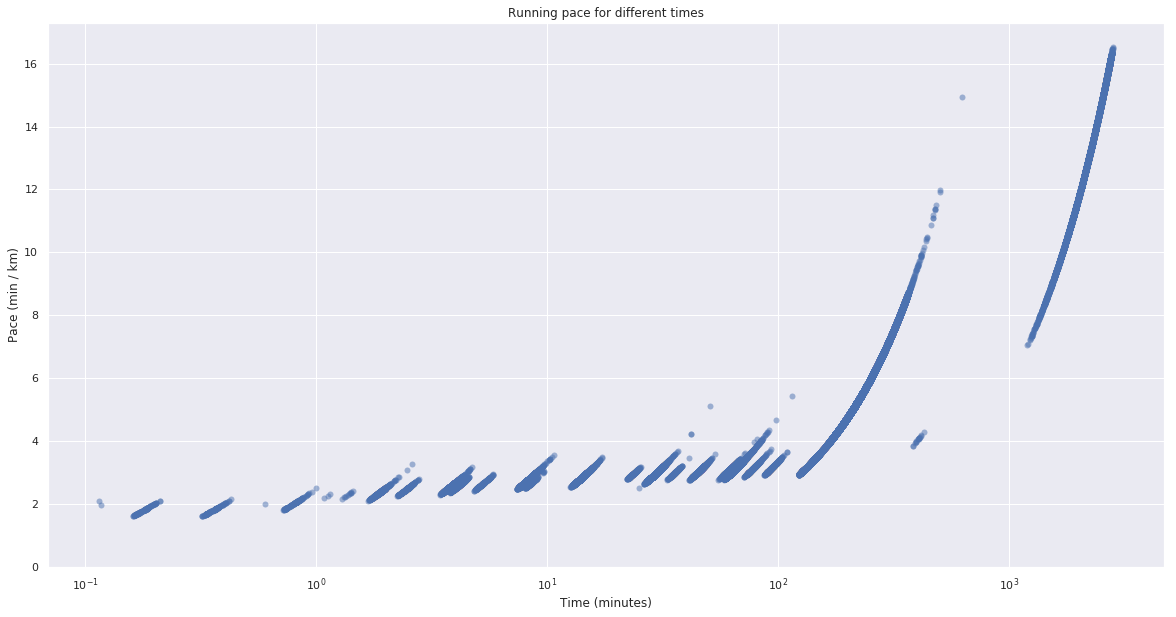

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.concat(dfs, sort=False)

plt.figure(figsize=[20,10])
sns.scatterplot(x='time', y='pace', data=df, linewidth=0, alpha=0.5)
plt.xlabel('Time (minutes)')
plt.ylabel('Pace (min / km)');
plt.ylim(bottom=0);
plt.xscale('log')
plt.title('Running pace for different times');

Interesting! There is a very clear boundary describing the *best* atheletes in the world. To me, there are two interesting features:

1. Enormous jumps in race time only lead to minor adjustments in pace (of the best runners).
2. Around 10 hours (600 minutes) there appears to be a "cliff".

The first observation seems like it is very well supported by the data. The second observation may merely be due to other factors, such as the fact that UTMB (the main data source for 1000+ minutes) is run in the Alps, which makes the best pace signficantly slower than a road race of the same distance.

How can we combine this into some sort of model? The simplest model that I can think of is that if we know that it is possible to sustain a pace $p_0$ for a time $t_0$, then any performance with $p \ge p_0$ or $t \le t_0$ should be possible. Then, to compute this, all we have to do is work from right to left (longest time to shortest time) and maintain a sorted list of paces observed for longer race times.

In [ ]:
def lower_bounds_from_right(x, y, maxk):
    idx = np.argsort(x)
    x,y = x[idx], y[idx]
    m = np.empty((len(y), maxk))
    m[-1,0] = y[-1]
    m[-1,1:] = np.nan
    for i in range(len(y)-2,-1,-1):
        j = np.searchsorted(m[i+1], y[i])
        m[i,:j] = m[i+1,:j]
        if j < maxk:
            m[i,j] = y[i]
            m[i,j+1:] = m[i+1,j:maxk-1]
    return x, m
            

times, lower_bound = lower_bounds_from_right(df.time.values, df.pace.values, 1000)

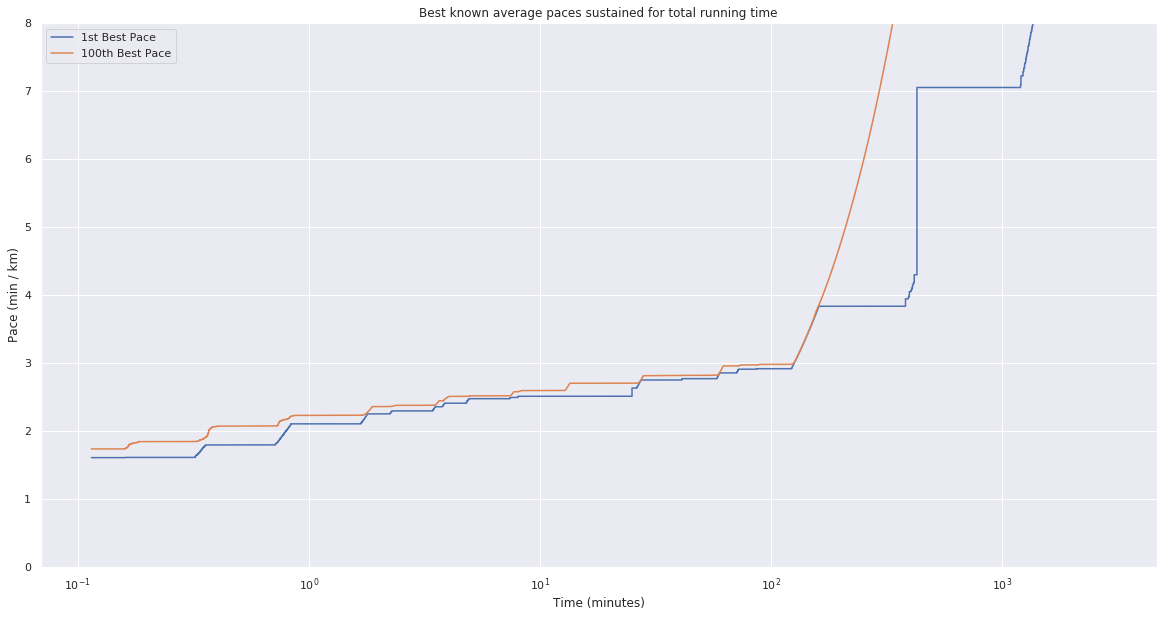

In [51]:
plt.figure(figsize=[20,10])
plt.step(x=times, y=lower_bound[:,0], label='1st Best Pace')
#plt.step(x=times, y=lower_bound[:,9], label='10th Best Pace')
plt.step(x=times, y=lower_bound[:,99], label='100th Best Pace')
#plt.step(x=times, y=lower_bound[:,999], label='1000th Best Pace')
plt.legend()
plt.xlabel('Time (minutes)')
plt.ylabel('Pace (min / km)')
plt.xscale('log')
plt.ylim([0,8])
plt.title('Best known average paces sustained for total running time');

That cleans up the plot significantly! I imagine that the 100th best pace is probably a more robust estimate
of the performance boundary than the all time best performance. Either way, I find this to be quite interesting.
Up to race times of about 100 minutes, the best pace is approximately logarithmically related to the length that
it was sustained for. I don't have a biological reason why this is the case.

I also find it interesting how consistent the boundary is (in regions with enough data). I am curious whether a
similar boundary exists for other types of human performance, either althletic or intellectual. For instance, a
company might be able to measure employee productivity against the number of hours (per week) that they work. I
imagine a similar curve would exist.